---
title: "Earthquake Data Analysis using Python & MongoDB"
author: "Barbara Maier"
number-sections: true
number-depth: 3

format:
  pdf:
    pdf-engine: xelatex          # empfohlen, v.a. mit Arial
    mainfont: Arial
    monofont: Consolas
    fontsize: 11pt
    toc: true
    highlight-style: tango
    code-font-size: 9pt          # Code etwas kleiner (optional)
    geometry:
      - top=20mm
      - bottom=20mm
      - left=20mm
      - right=20mm

    include-in-header:
      text: |
        \usepackage{xurl}        % Zeilenumbruch bei URLs
        \usepackage{fvextra}     % Erweiterte verbatim-Optionen

        % --- Codeblöcke (mit Farben) umbrechen ---
        % 'commandchars' behält die Syntaxfarben von Quarto/Pandoc
        \DefineVerbatimEnvironment{Highlighting}{Verbatim}
          {breaklines,breakanywhere,commandchars=\\\{\}}

        % --- Ausgaben (verbatim) umbrechen ---
        \RecustomVerbatimEnvironment{verbatim}{Verbatim}
          {breaklines,breakanywhere}

execute:
  echo: true
  warning: false
  message: false
---

# My Project Title
## Earthquake Data Analysis using Python & MongoDB

# Summary


This project analyzes recent earthquake data retrieved from the USGS API using Python and MongoDB.
The workflow includes data extraction, transformation, and storage in a NoSQL database for efficient querying.
Aggregations and visualizations are performed to explore earthquake frequency, magnitude distribution, and global locations.
The analysis demonstrates how MongoDB’s geospatial features and Python’s data tools can support real-world seismic data insights.

# Requirements & Configuration

In [1]:
# Check installed packages
!pip list 2>nul | findstr "pymongo pandas requests"

geopandas                 1.1.1
pandas                    2.3.3
pymongo                   4.15.1
requests                  2.32.5


In [2]:
# import packages
import pandas as pd 
import requests
import datetime as dt
from pymongo import MongoClient
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pprint import pprint

In [3]:
# pandas configuration
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 30)

In [4]:
# API and Database details
API_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"
CNX_STR = "mongodb://localhost:27017"
DB_NAME = "earthquakes_db"
COLL_NAME = "earthquakes"
START_UTC = datetime.utcnow() - timedelta(days=30)

# ELT Process

## DB Setup

In [5]:
# connection to MongoDB
client = MongoClient(CNX_STR)
db = client[DB_NAME]
quakes_col = db[COLL_NAME]

print("Connected with MongoDB (lokal)")

Connected with MongoDB (lokal)


In [6]:
# remove all existing documents
quakes_col.drop()
quakes_col.count_documents({})

0

## Extract

The dataset is extracted from the USGS Earthquake API.   Only the last 30 days are requested to keep the dataset manageable.  
Each record contains details such as magnitude, location, and time of the earthquake. The parameter `minmagnitude = 3.0` filters out very small, irrelevant events.  

In [7]:
# get url
url = API_URL

# earthquakes from the last 30 days
start = (dt.datetime.utcnow() - dt.timedelta(days=30)).strftime("%Y-%m-%d")
end = dt.datetime.utcnow().strftime("%Y-%m-%d")


# define API request parameters
params = {
    "format": "geojson",
    "starttime": start,
    "endtime": end,
    "minmagnitude":3,
}

# send request to the API, load the JSON response, and inspect the result
response = requests.get(url, params=params)
data = response.json()
quakes = data["features"]

# print info for check
print(f"Number of records: {len(quakes)}")

# format long key list with line breaks (wrap text)
from textwrap import fill
if quakes:
    keys = ", ".join(quakes[0]["properties"].keys())
    print(" All keys:")
    print(fill(keys, width=80))
else:
    print("No earthquake data found.")



Number of records: 1037
 All keys:
mag, place, time, updated, tz, url, detail, felt, cdi, mmi, alert, status,
tsunami, sig, net, code, ids, sources, types, nst, dmin, rms, gap, magType,
type, title


The output shows that the data was successfully loaded from the USGS Earthquake API.  
- **Number of records**: is the total number of earthquakes found in the last 30 days with magnitude ≥ 3.0.  
- **All keys**: main data fields for each earthquake, such as `mag` (magnitude), `place` (location) or `time` (UTC time).

## Load

In [8]:
# convert API earthquake features into MongoDB document structure
docs = []
for f in quakes:
    p = f["properties"]
    g = f.get("geometry", {}) or {}
    coords = g.get("coordinates") or [None, None, None]
    docs.append({
        "_id": f.get("id"),
        "time": dt.datetime.utcfromtimestamp(p["time"]/1000) if p.get("time") else None,
        "mag": p.get("mag"),
        "magType": p.get("magType"),
        "place": p.get("place"),
        "tsunami": p.get("tsunami", 0),
        "geometry": {"type": "Point", "coordinates": coords},
        "properties": p
    })
    
# Check for missing values (no filtering)
null_counts = {
    "mag": sum(d["mag"] is None for d in docs),
    "time": sum(d["time"] is None for d in docs),
    "coordinates": sum(
        not d["geometry"]["coordinates"]
        or None in d["geometry"]["coordinates"][:2]
        for d in docs
    )
}
print("Missing values:", null_counts)

# reset collection and insert
quakes_col.drop()
quakes_col = db[COLL_NAME]
res = quakes_col.insert_many(docs, ordered=False)
len(res.inserted_ids)



Missing values: {'mag': 0, 'time': 0, 'coordinates': 0}


1037

The Output shows, that there are no missing values in mag, time and coordinates.
    

## Transform

In this step, I prepare the earthquake data for analysis.  I add a simplified `date` field (without time) and create a geospatial index for location-based queries.  This makes later queries and aggregations faster and easier to handle.

The  added  field `date`was created in order to simplify time-based analysis.  The original `time` field contains timestamps in milliseconds,  but for grouping and trend analysis, it is easier to work with daily values.  Therefore, the `date` field stores only the day (without hours and minutes).

In [9]:
# Create indexes for faster queries
quakes_col.create_index([("geometry", "2dsphere")])
quakes_col.create_index([("time", 1)])

# Add a  field "date" (without time)
quakes_col.update_many({}, [
    {"$set": {
        "date": {"$dateTrunc": {"date": "$time", "unit": "day"}}
    }}
])

UpdateResult({'n': 1037, 'nModified': 1037, 'ok': 1.0, 'updatedExisting': True}, acknowledged=True)

In [10]:
r = quakes_col.aggregate([
    {"$project": {"_id": 0}},
    {"$limit": 1}
])
df_preview = pd.DataFrame(list(r))

dfp = df_preview.copy()
if 'geometry' in dfp.columns:
    dfp['geometry'] = dfp['geometry'].astype(str).str.slice(0, 50) + '…'
from pprint import pprint
for _, row in df_preview.iterrows():
    print(f"\n🟦 Document:")
    pprint(row.to_dict(), width=80, compact=True)




🟦 Document:
{'date': Timestamp('2025-11-02 00:00:00'),
 'geometry': {'coordinates': [-94.1893, 17.7673, 191.709], 'type': 'Point'},
 'mag': 5,
 'magType': 'mb',
 'place': '18 km SSW of Las Choapas, Mexico',
 'properties': {'alert': None,
                'cdi': 2,
                'code': '6000rl3p',
                'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000rl3p&format=geojson',
                'dmin': 2.457,
                'felt': 1,
                'gap': 63,
                'ids': ',us6000rl3p,',
                'mag': 5,
                'magType': 'mb',
                'mmi': None,
                'net': 'us',
                'nst': 75,
                'place': '18 km SSW of Las Choapas, Mexico',
                'rms': 0.58,
                'sig': 385,
                'sources': ',us,',
                'status': 'reviewed',
                'time': 1762125570415,
                'title': 'M 5.0 - 18 km SSW of Las Choapas, Mexico',
                'tsu

This step checks the stored fields in the database and displays a sample document to verify the data structure.

# Datastructure

The dataset is stored in a MongoDB database (earthquakes_db) containing a single collection named earthquakes.
Each document represents one earthquake event and includes both simple fields and two embedded objects: geometry and properties.
The structure is ***denormalized***, meaning that all related data is stored within a single document, including the embedded fields.

### Document Structure Diagram


```
+---------------------------------------------------------------+
|                        Earthquakes                            |
|---------------------------------------------------------------|
| _id, time, date, mag, magType, place, tsunami                 |
|                                                               |
|  +------------------+     +---------------------------------+ |
|  |    Geometry      |     |            Properties           | |
|  |------------------|     |---------------------------------| |
|  | type             |     | mag, place, time, updated, tz,  | |
|  | coordinates[3]   |     | url, detail, felt, cdi, mmi,    | |
|  |                  |     | alert, status, tsunami, sig,    | |
|  |                  |     | net, code, ids, sources, types, | |
|  |                  |     | nst, dmin, rms, gap, magType,   | |
|  |                  |     | type, title                     | |
|  +------------------+     +---------------------------------+ |
+---------------------------------------------------------------+
```

\newpage

### Class Diagram 
In order to illustrate the 1:1 relationship between these components more clearly, a Class Diagram is also presented below.    

![Diagram](diagram.png)

Each earthquake document contains exactly one geometry and one properties object, represented here as 1-to-1 relationships.
The open circle in the diagram indicates that these links are technically optional, but in practice they exist for every record in the dataset.

# Data Analysis

### Earthquakes Worldwide in the Past 10 Days 

In [11]:
  # group earthquake by day and calculate Magnitude
r = quakes_col.aggregate([
    {"$group": {"_id": "$date", "count": {"$sum": 1}, "avgMag": {"$avg": "$mag"}}},
    {"$sort": {"_id": 1}}
])

# transform into a dataframe for better visualisation
df_daily = pd.DataFrame(list(r)).rename(columns={"_id": "date"})
df_daily.head(10)


,date,count,avgMag
0,2025-10-04,62,4.32
1,2025-10-05,66,4.42
2,2025-10-06,55,4.24
3,2025-10-07,54,4.29
4,2025-10-08,38,4.21
5,2025-10-09,22,4.47
6,2025-10-10,82,4.81
7,2025-10-11,42,4.66
8,2025-10-12,38,4.25
9,2025-10-13,32,4.36


The dataset shows daily earthquake activity over the past 10 days worldwide. The number of earthquakes per day varies between roughly 30 and 60. The average magnitude is typically around 4.2 to 4.6, which indicates mostly moderate events. 

Since all earthquakes below a magnitude of 3.0 were removed, the actual total number of earthquakes would be higher and average magnitude of earthquakes during this period would be lawer. However, events below 3.0 were excluded because such weak quakes are generally not perceptible to humans.


### Earthquake Magnitude Scale

To better understand the relationship between earthquake magnitude and its potential impact, the following diagram presents the magnitude scale and corresponding typical effects.

![Diagram](magnitude.png)

*Source: Adapted from GeoVera Insurance (2023), “Richter Scale – Earthquake Magnitude and Typical Effects”.*\
<pr>


### Recent Major Earthquakes
To understand recent seismic activity, let’s look at where the strongest earthquakes (magnitude 6.0 and above) have occurred worldwide during the past 30 days.   

In [12]:
# List only earthquakes with a magnitude above 6.0
pipeline = [
    {"$match": {"mag": {"$gte": 6.0}}},
    {"$project": {
        "_id": 0,
        "place": 1,
        "mag": 1,
        "date": 1
    }},
    {"$sort": {"mag": -1}},  # sort decreasing
    {"$limit": 10}
]

# Run aggregation
df = pd.DataFrame(list(quakes_col.aggregate(pipeline)))

# Prevent table from being split in Quarto PDF
from IPython.display import HTML, display
display(HTML("<div style='page-break-inside: avoid'>" + df.to_html(index=False) + "</div>"))


mag,place,date
7.6,Drake Passage,2025-10-10
7.4,"20 km E of Santiago, Philippines",2025-10-10
6.7,"23 km ESE of Santiago, Philippines",2025-10-10
6.6,"20 km W of Lae, Papua New Guinea",2025-10-07
6.5,"194 km WNW of Abepura, Indonesia",2025-10-16
6.5,"162 km E of Beauséjour, Guadeloupe",2025-10-27
6.4,Banda Sea,2025-10-28
6.3,"134 km SE of Lorengau, Papua New Guinea",2025-10-10
6.3,Drake Passage,2025-10-16
6.3,"22 km WSW of Khulm, Afghanistan",2025-11-02


The strongest event (mag 7.6) occurred in the Drake Passage — a deep oceanic region between South America and Antarctica.
Other major earthquakes were located around the Philippines, Papua New Guinea, and Indonesia, regions that form part of the Pacific Ring of Fire.

### Global Earthquakes in the Past 30 Days

To visualize recent global seismic activity, the following map displays all earthquakes recorded within the last 30 days, highlighting regions with frequent and intense events.

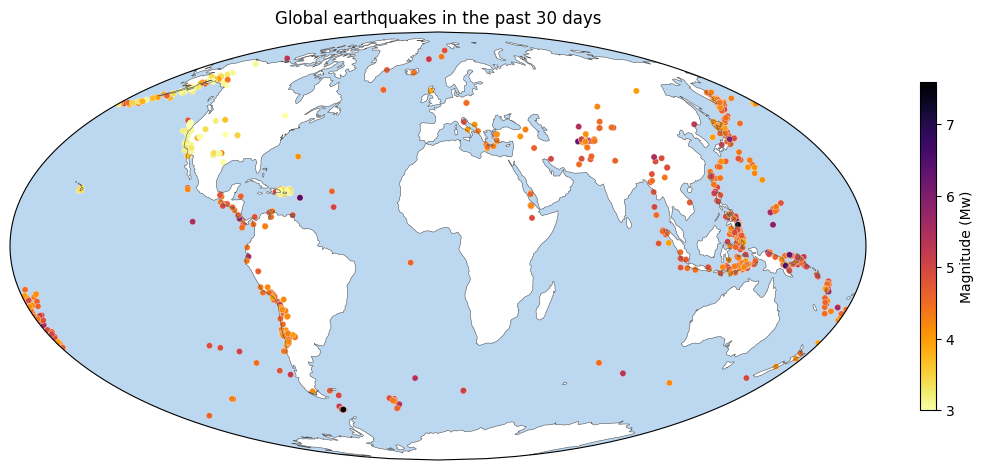

In [13]:
# Get coordinates and magnitude fields for  mapping
pipe = [{"$project":{"_id":0,"mag":1,
                     "lon":{"$arrayElemAt":["$geometry.coordinates",0]},
                     "lat":{"$arrayElemAt":["$geometry.coordinates",1]}}}]

# load and clean data
df = pd.DataFrame(quakes_col.aggregate(pipe))
df["mag"] = pd.to_numeric(df["mag"], errors="coerce")
df = df.dropna(subset=["mag","lon","lat"]).query("-90 <= lat <= 90 and -180 <= lon <= 180")
fig = plt.figure(figsize=(11,5))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_global()

# Add ocean color and coastlines
ax.add_feature(cfeature.OCEAN, facecolor="#bcd7f0")
ax.coastlines(linewidth=0.4, color="#555")

# Plot earthquakes (size, color by magnitude)
sc = ax.scatter(df["lon"], df["lat"],
                s=20, c=df["mag"],
                cmap="inferno_r",          # darker = stronger
                transform=ccrs.PlateCarree(),
                edgecolors="white", linewidths=0.2)

# Add colorbar, title, and show
plt.colorbar(sc, ax=ax, shrink=0.7).set_label("Magnitude (Mw)")
plt.title("Global earthquakes in the past 30 days")
plt.tight_layout()
plt.show()


The map shows all recorded earthquakes from the past 30 days. Each dot represents one event, where darker colors mean stronger magnitudes.

Most earthquakes occur along tectonic plate boundaries, especially around the Pacific Ocean (“Ring of Fire”). Earthquakes are particularly dense in regions such as Japan, Indonesia, and the west coast of the Americas, where several major plates meet. 

The relative scarcity of events in areas like Africa and northern Europe reflects their position within stable continental interiors. This visualization emphasizes how global seismic activity is closely tied to the movement and interaction of Earth’s tectonic plates.


### Daily Earthquakes

The following chart illustrates the daily number of recorded earthquakes during the past 30 days, revealing short-term fluctuations in global seismic activity.

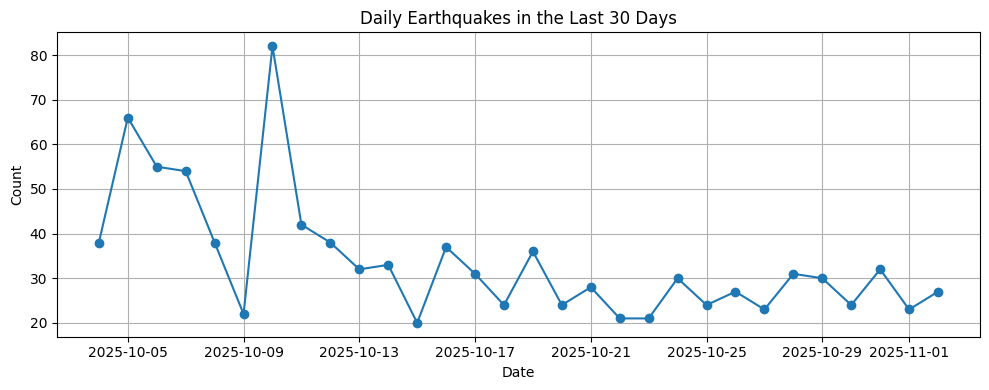

In [14]:
# define aggregation pipeline
pipe = [
    {"$match": {"time": {"$gte": START_UTC}}},
    {"$group": {"_id": "$date", "count": {"$sum": 1}}},
    {"$sort": {"_id": 1}}
]
# load and prepare data
df_daily = pd.DataFrame(quakes_col.aggregate(pipe)).rename(columns={"_id":"date"})
df_daily["date"] = pd.to_datetime(df_daily["date"])

# plot daily earthquake counts
plt.figure(figsize=(10,4))
plt.plot(df_daily["date"], df_daily["count"], marker="o")
plt.title("Daily Earthquakes in the Last 30 Days")
plt.xlabel("Date"); plt.ylabel("Count"); plt.grid(True); plt.tight_layout(); plt.show()



The graph shows noticeable fluctuations in daily earthquake activity, with a peak of around 70 events on October 10, 2025. 
Overall, a slight decreasing trend can be observed toward the end of the observation period.

### Spatial Distribution of the 70 Earthquakes Recorded on October 10, 2025 

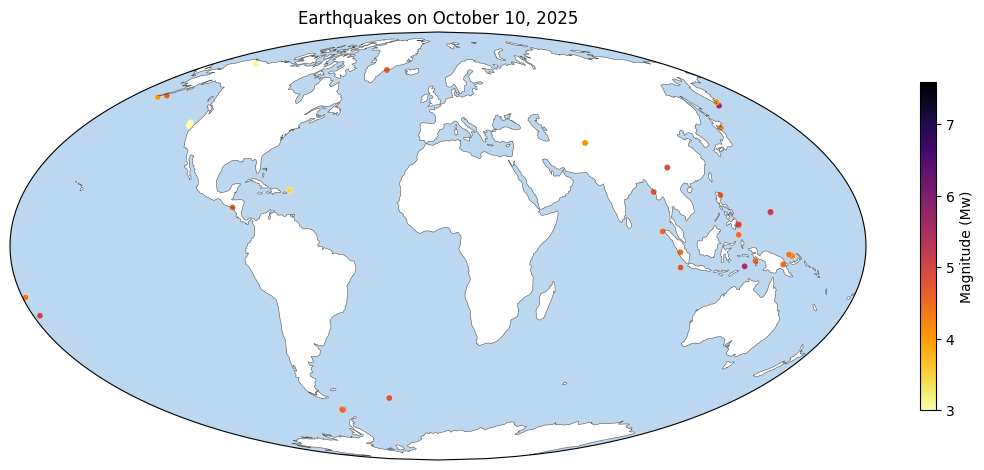

In [15]:
# define date range for one day
start_date = datetime(2025,10,10); end_date = start_date + timedelta(days=1)

# build the pipeline
pipe = [
    {"$match": {"time": {"$gte": start_date, "$lt": end_date}}},
    {"$project":{"_id":0,"mag":1,
                 "lon":{"$arrayElemAt":["$geometry.coordinates",0]},
                 "lat":{"$arrayElemAt":["$geometry.coordinates",1]}}}
]
# load an clean data
df = pd.DataFrame(quakes_col.aggregate(pipe))
df["mag"] = pd.to_numeric(df["mag"], errors="coerce")
df = df.dropna(subset=["mag","lon","lat"]).query("-90 <= lat <= 90 and -180 <= lon <= 180")

# create global map
fig = plt.figure(figsize=(11,5))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_global()
ax.add_feature(cfeature.OCEAN, facecolor="#bcd7f0")
ax.coastlines(linewidth=0.4, color="#555")

# plot earthquakes
sc = ax.scatter(df["lon"], df["lat"],
                s=20, c=df["mag"], cmap="inferno_r",
                transform=ccrs.PlateCarree(),
                edgecolors="white", linewidths=0.2)

plt.colorbar(sc, ax=ax, shrink=0.7).set_label("Magnitude (Mw)")
plt.title("Earthquakes on October 10, 2025")
plt.tight_layout()
plt.show()


The spatial pattern indicates that the majority of earthquakes on October 10, 2025, occurred near the Philippines and Indonesia. This region is part of the Pacific “Ring of Fire,” where the interaction of several tectonic plates causes frequent and sometimes powerful seismic events. 

### How many of the earthquakes on October 10, 2025, occurred around the Philippines?

Based on the previous global map, most earthquakes on October 10, 2025, appeared to cluster around the Philippines.
To verify this observation quantitatively, the following query filters all events within a 1000 km radius of the Philippine region using both spatial and time indexes in MongoDB.

In [16]:

# Philippines
center = {"type": "Point", "coordinates": [122.0, 12.0]}  # [lon, lat]

# Date range for October 10, 2025
start_date = datetime(2025, 10, 10)
end_date = start_date + timedelta(days=1)

# Query for quakes on that date around the Philippines
query = {
    "time": {"$gte": start_date, "$lt": end_date},  # uses time index
    "geometry": {                                   # uses 2dsphere index
        "$near": {
            "$geometry": center,
            "$maxDistance": 1000000                # 1000 km radius
        }
    }
}
# print the results
results = list(quakes_col.find(query, {"place": 1, "mag": 1, "_id": 0}))  # <- limit(70) entfernen!
print(f"\nEarthquakes around Philippines on {start_date.date()}: {len(results)} found")



Earthquakes around Philippines on 2025-10-10: 42 found


The result shows that 42 earthquakes occurred near the Philippines on that day, confirming that the majority of seismic activity was concentrated in this area. 
    

### Where was the main cluster of earthquakes on October 10, 2025?

To identify whether the earthquakes on October 10, 2025, were concentrated in a specific region on the Philippines, the following aggregation groups all events by rounded latitude and longitude. This approach highlights spatial clusters of seismic activity (not a single epicenter).

In [17]:
# define date range for analysis 
s,e = datetime(2025,10,10), datetime(2025,10,11)

# aggregate earthquakes by rounded coordinates 
pipe = [
  {"$match":{"time":{"$gte":s,"$lt":e}}},
  {"$project":{
      "cellLat":{"$round":[{"$arrayElemAt":["$geometry.coordinates",1]},1]},
      "cellLon":{"$round":[{"$arrayElemAt":["$geometry.coordinates",0]},1]}
  }},
  {"$group":{"_id":{"lat":"$cellLat","lon":"$cellLon"}, "count":{"$sum":1}}},
  {"$sort":{"count":-1}}, {"$limit":10}
]
# display the most active regions (potential seismic clusters)
list(quakes_col.aggregate(pipe))


[{'_id': {'lat': 7.1, 'lon': 126.8}, 'count': 4},
 {'_id': {'lat': 7.2, 'lon': 127.3}, 'count': 4},
 {'_id': {'lat': 7.1, 'lon': 126.9}, 'count': 3},
 {'_id': {'lat': 7.2, 'lon': 127.0}, 'count': 3},
 {'_id': {'lat': 7.3, 'lon': 126.8}, 'count': 3},
 {'_id': {'lat': 6.9, 'lon': 126.8}, 'count': 2},
 {'_id': {'lat': 7.2, 'lon': 127.1}, 'count': 2},
 {'_id': {'lat': 7.4, 'lon': 127.1}, 'count': 2},
 {'_id': {'lat': 7.1, 'lon': 127.2}, 'count': 2},
 {'_id': {'lat': -60.1, 'lon': -62.5}, 'count': 2}]

The aggregation shows a clear spatial concentration of earthquakes on October 10, 2025.
Most events occurred around 7° N, 127° E, indicating an active cluster near the Philippine Trench, east of Mindanao.
Several nearby cells (7.1–7.4° N, 126.8–127.3° E) also recorded multiple quakes, supporting the presence of a localized seismic hotspot.
Only a few isolated events appeared elsewhere.

### Tsunami-Flagged Earthquakes in the Past 30 Days

To assess the tsunami risk among recent seismic events, the query counts how many earthquakes were flagged as tsunami-related during the past 30 days, and specifically on October 10, 2025 — the day with the highest earthquake activity.

In [18]:
# define time windows 
s = datetime(2025, 10, 10)
e = s + timedelta(days=1)   

# aggregation: count tsunami-flagged events
pipe = [
    {"$match": {"tsunami": {"$gt": 0}}},        # include only tsunami-flagged events
    {"$facet": {                                # parallel sub-queries
        "last30": [
            {"$match": {"time": {"$gte": START_UTC}}},
            {"$count": "n"}
        ],
        "oct10": [
            {"$match": {"time": {"$gte": s, "$lt": e}}},
            {"$count": "n"}
        ]
    }}
]

# execute and extract results 
res = list(quakes_col.aggregate(pipe))[0]
n30   = res["last30"][0]["n"] if res["last30"] else 0
n1010 = res["oct10"][0]["n"] if res["oct10"] else 0

# print summary
print(f"Tsunami-flagged in last 30 days: {n30}  |  on {s.date()}: {n1010}")

Tsunami-flagged in last 30 days: 11  |  on 2025-10-10: 3


The result shows that 11 tsunami-flagged earthquakes occurred globally within the last 30 days, 3 of which happened on October 10, 2025.

This suggests that several of the strong earthquakes on that day may have been powerful enough to trigger tsunami warnings, indicating elevated seismic–oceanic interaction in the region.

# Conclusions

This project demonstrated the complete workflow of building a data pipeline with Python and MongoDB — from data extraction to visualization and insight generation. Using the USGS Earthquake API, I collected global earthquake data from the past 30 days and stored it in a NoSQL database for further analysis. During the ELT process, I prepared and indexed the data to support efficient time-based and geospatial queries, enabling high-performance exploration of temporal and spatial patterns.

The analytical phase included several MongoDB aggregations that revealed key patterns in recent seismic activity. Grouping earthquakes by day showed strong fluctuations in the number of events, with a noticeable peak around October 10, 2025. When filtering by magnitude, the data highlighted that most earthquakes fall within a moderate range (Mw 4–5), while only a few reach magnitudes above 6.0. Mapping the global distribution made clear that most seismic activity is concentrated along tectonic plate boundaries, especially around the Pacific Ring of Fire — including regions such as the Philippines, Indonesia, and Chile.

A focused analysis on October 10 revealed that over 70 earthquakes occurred on that single day, about half of them near the Philippines, suggesting a regional cluster or local swarm activity. Further investigation of tsunami-flagged events showed that 10 earthquakes in the last 30 days were identified as potentially tsunami-inducing, including three events on October 10. This supports the interpretation of elevated oceanic–seismic coupling in that region.

Overall, this project demonstrates how combining MongoDB’s aggregation framework with Python’s analytical ecosystem can effectively uncover both global and temporal patterns in real-world datasets. It also highlights the importance of data transformation, indexing, and visualization in turning raw event data into meaningful geophysical insights, capable of supporting both scientific interpretation and practical hazard awareness.

# Learnings

While working on this project, I learned how to build a complete data pipeline — from collecting live data via the USGS API to cleaning, transforming, storing, and analyzing it in MongoDB. I became much more confident in using MongoDB’s aggregation framework and understood how powerful it is for handling nested data and filtering with complex conditions.

At first, the aggregation code seemed very abstract, but after trying many queries and debugging them with the help of ChatGPT, I finally understood how each stage works and how they can be combined to filter, group, and count data efficiently. I spent a lot of time experimenting, fixing errors, and understanding how all the parts of the workflow fit together — from data collection to the final report.

One of the biggest challenges was getting the results to display correctly in Quarto. I struggled with formatting issues for hours — especially with long code outputs and wide tables — but through this process, I learned how to control layout, wrapping, and font settings much better. I now understand how Quarto handles code cells and Markdown much more clearly.

I also learned how to visualize data effectively with Matplotlib and Cartopy, and how different map projections and color scales can change the interpretation of results.

Overall, this project taught me not just technical skills, but also patience, precision, and persistence — and how valuable it is to truly understand the cause of an error instead of just trying to fix it quickly. 
